In [ ]:
!pip install transformers
!pip install datasets

In [45]:
from transformers import BertForSequenceClassification, BertTokenizer
from datasets import load_dataset, load_metric, load_from_disk
from torch.utils.data import DataLoader, SequentialSampler
from functools import partial
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import gc
from scipy import stats
import numpy as np
import json
import seaborn as sns

In [ ]:
sns.set_style('darkgrid')

In [46]:
model = BertForSequenceClassification.from_pretrained('A-bhimany-u08/bert-base-cased-qqp')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [47]:
acc = load_metric('accuracy')

In [48]:
dataset = load_dataset('glue', 'qqp', split = 'validation')

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/qqp/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


In [ ]:
eval_dataset = dataset.map(lambda examples: tokenizer(examples['question1'], examples['question2'], padding= True), batch_size= 32, batched= True)

In [ ]:
eval_dataset = eval_dataset.map(lambda examples: {'labels': examples['label']}, batched= True)

In [ ]:
eval_dataset.set_format(type = "torch", columns = ['token_type_ids', 'attention_mask', 'input_ids', 'labels'])

In [ ]:
eval_dataloader = DataLoader(eval_dataset, batch_size = 32, sampler = SequentialSampler(eval_dataset))

In [ ]:
def calculate_rest_sep_attention(attention_maps, input_ids, pad_token_id, sep_token_id, device):
    '''attention_maps of shapes (bs, num_layer, num_heads, batch_len, batch_len)
       input_ids of shapes (batch_size, batch_len)'''
    
    batch_size,num_layers,num_heads,batch_len,_ = attention_maps.size()
    rest_sep = torch.zeros(num_layers, num_heads).to(device)
    for batch in range(batch_size):
        ids = input_ids[batch].detach()
        try:
            seq_len = next(i for i in range(len(ids)) if ids[i] == pad_token_id) #calculating the length of sequence without padding tokens.
        except:
            seq_len = batch_len
#         seq_len = attn_map['attention_map'].size(-1)
        attn_map = attention_maps[batch].detach()[:, :, :seq_len, :seq_len]
        ids = ids[:seq_len]
#         print(seq_len, ids)
        mask1 = (ids == sep_token_id)[None,None,None,:].to(device) #mask along the row to remove attention to tokens other than SEP
        mask2 = (ids == sep_token_id)[None,None,:,None].to(device) #mask along the column to remove attention from SEP tokens.
    
#         print(mask1, mask2)

        rest_sep += attn_map.masked_fill(~mask1, 0).masked_fill(mask2,0).sum(-1).sum(-1)/(seq_len-2)
        
    return rest_sep

In [ ]:
def calculate_head_importance(model, dataloader, pad_token_id, sep_token_id, device = 'cuda'):
    
    '''
    This function calculates head_importance (using method put forward in https://arxiv.org/abs/1905.10650) and res_sep_attention
    '''
    
    model = model.to(device)
    head_mask = torch.ones(model.config.num_hidden_layers, model.config.num_attention_heads).to(device)
    head_importance = torch.zeros_like(head_mask).to(device)
    rest_sep_attention = torch.zeros_like(head_mask).to(device)
    
    head_mask.requires_grad_(requires_grad = True)
    tot_tokens= 0
    for batch in tqdm(dataloader):
        for i,j in batch.items():
            batch[i] = j.to(device)
            
        out = model(**batch, head_mask = head_mask, output_attentions = True)
        
        out.loss.backward()
        
        attention_maps = torch.stack(out.attentions, dim = 0).transpose(0,1)
        rest_sep_attention += calculate_rest_sep_attention(attention_maps, batch['input_ids'], pad_token_id, sep_token_id, device = device)
        head_importance += head_mask.grad.abs().detach()
        tot_tokens += batch['attention_mask'].float().detach().sum().data
        
    head_importance /= tot_tokens 
    rest_sep_attention /= len(dataloader.dataset)
    
    return head_importance, rest_sep_attention
            
    

In [ ]:
head_imp, res_sep_attn = calculate_head_importance(model, eval_dataloader, tokenizer.pad_token_id, tokenizer.sep_token_id)

In [ ]:
head_imp = head_imp.cpu()
res_sep_attn = res_sep_attn.cpu()

In [34]:
# head_imp = torch.load('/content/drive/MyDrive/attention_head/head_imp.pkl')
# res_sep_attn = torch.load('/content/drive/MyDrive/attention_head/res_sep_attn.pkl')

In [35]:
def normalize(mat):
    return (mat-mat.mean())/(mat.std())

In [36]:
head_imp_normalised, res_sep_attn_normalised = map(normalize, (head_imp, res_sep_attn))

In [40]:
def calculate_covariance_correlation(arr1, arr2):
    
    cov = (arr1*arr2).mean() - arr1.mean()*arr2.mean()
    corr = cov/(arr1.std()* arr2.std())
    
    return cov.item(), corr.data.item()
    

In [37]:
def get_points(matrix):
    num_layers, num_heads = matrix.size()
    layer_num, head_values, average_across_layer = [],[],[]
    for layer in range(num_layers):
        for head in range(num_heads):
            head_values.append(matrix[layer,head])
            layer_num.append(1+layer)
            
        average_across_layer.append(matrix[layer,:].mean(dim = -1))
        
        
    return layer_num, head_values, average_across_layer

In [38]:
def plot_averages(matrix,ax, label, head_color, avg_color, ylabel):
    xs, ys, averages = get_points(matrix)
    ax.scatter(xs, ys, label = label, color = head_color)
    
    ax.plot(1+ np.arange(len(averages)), averages, color = avg_color)
    ax.legend(loc = "best")
    ax.set_xlabel("Layer")
    ax.set_ylabel(ylabel)

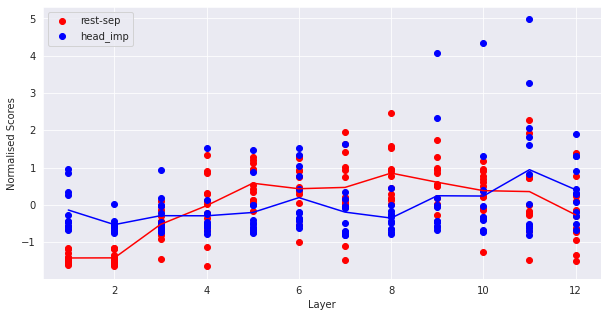

In [39]:
plt.figure(figsize = (10,5))

ax1 = plt.subplot(1,1,1)
plot_averages(res_sep_attn_normalised, ax1, 'rest-sep', 'red', 'red', 'Average REST-SEP attention')

plot_averages(head_imp_normalised, ax1, 'head_imp', 'blue', 'blue', 'Normalised Scores')


In [49]:
for layer in range(model.config.num_hidden_layers):
        print(f'Layer ->{layer}, correlation -> {calculate_covariance_correlation(head_imp[layer, :], res_sep_attn[layer, :])[1]}')

Layer ->0, correlation -> -0.5367436408996582
Layer ->1, correlation -> 0.45760104060173035
Layer ->2, correlation -> -0.41785088181495667
Layer ->3, correlation -> -0.5498131513595581
Layer ->4, correlation -> -0.646125316619873
Layer ->5, correlation -> -0.0016403688350692391
Layer ->6, correlation -> -0.18465787172317505
Layer ->7, correlation -> -0.4094505310058594
Layer ->8, correlation -> -0.4784487783908844
Layer ->9, correlation -> -0.7705582976341248
Layer ->10, correlation -> -0.4376329779624939
Layer ->11, correlation -> -0.08528419584035873


In [ ]:
def listify(item):
    if isinstance(item, list): return item
    else: return [item]

In [ ]:
def calculate_pvalue(pred1, pred2, labels, metric):

  '''Calculate the pvalues for the two sets of predictions
    pvalue is important only when the pruned models accuracy is better than full model's and pvalue is <0.01 (denoting statistical significance). 
    That would mean that pruned model will give better accuracy more often than not on data with similar distribution when pruned similarly. Test statistic is 
    assumed to belong to t-distribution.
  '''
  acc1 = metric.compute(predictions = pred1, references = labels)['accuracy']
  acc2 = metric.compute(predictions = pred2, references = labels)['accuracy']

  mean = acc1 - acc2

  differences = torch.eq(pred1, labels).float() - torch.eq(pred2, labels).float()
  std = differences.std()

  test_statistic = (mean*np.sqrt(len(labels)))/std.numpy()
  pvalue = stats.t.sf(np.abs(test_statistic), len(labels)-1)*2

  return pvalue

In [ ]:
def prune_and_evaluate_model(model, dataloader, metric, rest_sep_attn, head_imp_scores = None,full_model_predictions = [], pruning_interval = 8, 
                             device = 'cuda', strategy = 'rest_sep', testing = False):
  
    '''
    This function prunes `pruning_interval` heads at a time according to the `strategy` and calculates the performance of the pruned model
    model -> model to evaluate and prune
    dataloader -> eval dataloader used to test the model. It's of instance torch.utils.data.DataLoader
    metric -> metric to judge the model by
    rest_sep_attn -> matrix of shape (num_layers, num_heads) where res_sep_attn[i,j] tells the average attention paid to [SEP] token in head j of layer i.
    head_imp_scores -> matrix of shape (num_layers, num_heads) where head_imp_scores[i,j] tells the importance of head j of layer i  to the model's predictions.
    full_model_predictions -> predictions of the full model (w/o any pruned heads) on the eval_dataset
    pruning_interval -> Number of heads to prune each time before calculating the metric on pruned model
    strategy -> Three options: rest_sep -> Prune the heads in decreasing order of average attention paid to the SEP token
                              head_imp -> Prune the heads in increasing order of their importance score
                              random -> prune randomly and cause chaos
    '''
      
    model = model.to(device)
    model.eval()
    
    total_heads = model.config.num_hidden_layers*model.config.num_attention_heads
    if strategy ==  'rest_sep': #Prune the heads in decreasing order of average attention paid to the SEP token
      print('Heads will be pruned based on rest_sep attention scores')
      topk = torch.topk(rest_sep_attn.view(-1), k = total_heads).indices

    elif strategy == 'head_imp': #Prune the heads in increasing order of their importance score
      print('Heads will be pruned based on head_imp scores')
      topk = torch.topk(head_imp_scores.view(-1), k = total_heads, largest = False).indices

    else: ##randomly pick heads to prune
      print('Heads will be pruned randomly')
      topk = torch.randperm(total_heads) 


    head_mask = torch.ones(total_heads).to(device)
    
    accuracies = []
    pvalues = []


    labels = dataloader.dataset['labels']

    if len(full_model_predictions) == 0 and not testing: #calculating predictions by full model (without any heads pruned) to compare to pruned models' predictions

      full_model_predictions = []
      for batch in tqdm(dataloader, desc = 'calculating full model predictions'):
        for i,j in batch.items():
          batch[i] = j.to(device)
                  
        out = model(**batch)

        preds = torch.argmax(out.logits, dim = -1)

        full_model_predictions.append(preds.clone().cpu())

        gc.collect()

      full_model_predictions = torch.cat(full_model_predictions, dim = 0)

    start_index = 0
    prune_dict = {i:[] for i in range(model.config.num_hidden_layers)} #dictionary with layer numbers as keys and heads numbers for heads to prune as corresponding value

    while start_index < len(topk):

      indexes = topk[start_index: start_index + pruning_interval].to(device)
      start_index += pruning_interval
      
      head_mask.index_fill_(0, indexes, 0)
      hm = head_mask.reshape(model.config.num_hidden_layers, model.config.num_attention_heads)

      pruned_heads = 0
      for layer in range(len(hm)):
        heads_to_prune = listify((1 - hm[layer].long()).nonzero().squeeze().tolist())
        heads_already_pruned = prune_dict[layer]
        for head in heads_to_prune:
          if head not in heads_already_pruned and len(prune_dict[layer]) < len(hm)-1: prune_dict[layer].append(head)
            
        pruned_heads += len(prune_dict[layer])


      pruned_predictions = []

      model.prune_heads(prune_dict)
      num_elem = sum(p.numel() for p in model.parameters()) #calculate the no of parameters in pruned model

      for batch in tqdm(dataloader, desc = f'Pruned {pruned_heads} heads, num params = {num_elem}'):
        for i,j in batch.items():
            batch[i] = j.to(device)
              
        out = model(**batch)

        preds = torch.argmax(out.logits, dim = -1)
        
        metric.add_batch(predictions = preds, references = batch['labels'])
        pruned_predictions.append(preds.clone().cpu())

      if not testing: 
        accuracies.append(metric.compute()['accuracy'])
        pruned_predictions= torch.cat(pruned_predictions, dim = 0)
        pvalue = calculate_pvalue(full_model_predictions, pruned_predictions, labels, metric)

        pvalues.append(pvalue)

    return accuracies,pvalues,full_model_predictions


In [ ]:
rsa_accuracies, rsa_pvalues, full_predictions = prune_and_evaluate_model(model, eval_dataloader, acc, res_sep_attn, pruning_interval= 4, 
                                                                  testing = False, strategy = 'rest_sep')

calculating full model predictions:   0%|          | 0/1264 [00:00<?, ?it/s]

Heads will be pruned based on rest_sep attention scores


Pruned 132 heads, num params = 82334210: 100%|██████████| 1264/1264 [01:30<00:00, 13.99it/s]


In [ ]:
with open('/content/drive/MyDrive/attention_head/rest_sep_stats.json', 'w') as file:
  json.dump({'accuracies':rsa_accuracies, 'pvalues':rsa_pvalues, 'full_model_predictions': full_predictions.tolist()}, file)

In [ ]:
model = BertForSequenceClassification.from_pretrained('A-bhimany-u08/bert-base-cased-qqp')

In [ ]:
hi_accuracies, hi_pvalues, _ = prune_and_evaluate_model(model, eval_dataloader, acc, res_sep_attn, pruning_interval= 4, full_model_predictions = full_predictions, head_imp_scores= head_imp,
                                                                  testing = False, strategy = 'head_imp')

Pruned 4 heads, num params = 107524610:   0%|          | 0/1264 [00:00<?, ?it/s]

Heads will be pruned based on head_imp scores


Pruned 132 heads, num params = 82334210: 100%|██████████| 1264/1264 [01:30<00:00, 14.02it/s]


In [ ]:
with open('/content/drive/MyDrive/attention_head/head_imp_stats.json', 'w') as file:
  json.dump({'accuracies':hi_accuracies, 'pvalues':hi_pvalues}, file)

In [ ]:
model = BertForSequenceClassification.from_pretrained('A-bhimany-u08/bert-base-cased-qqp')

In [ ]:
random_accuracies,random_pvalues,_ = prune_and_evaluate_model(model, eval_dataloader, acc, res_sep_attn, strategy = 'random', 
                                                            full_model_predictions = full_predictions, pruning_interval = 4)

Pruned 132 heads, num params = 82334210: 100%|██████████| 1264/1264 [01:53<00:00, 11.15it/s]


In [ ]:
with open('/content/drive/MyDrive/attention_head/random_stats_1.json', 'w') as file:
  json.dump({'accuracies':random_accuracies, 'pvalues':random_pvalues}, file)

## Plotting The Accuracies From Different Pruning Strategy

In [4]:
with open('/content/drive/MyDrive/attention_head/head_imp_stats.json', 'r') as file:
  head_imp_stats = json.load(file)

In [3]:
with open('/content/drive/MyDrive/attention_head/rest_sep_stats.json', 'r') as file:
  rest_sep_stats = json.load(file)

In [5]:
with open('/content/drive/MyDrive/attention_head/random_stats_1.json', 'r') as file:
  random_stats = json.load(file)

In [6]:
rsa_accuracies = rest_sep_stats['accuracies']
random_accuracies = random_stats['accuracies']
head_imp_accuracies = head_imp_stats['accuracies']

In [15]:
rsa_accuracies, random_accuracies, head_imp_accuracies = map(np.array, (rsa_accuracies, random_accuracies, head_imp_accuracies))

In [8]:
xaxis = np.arange(len(rsa_accuracies))*4

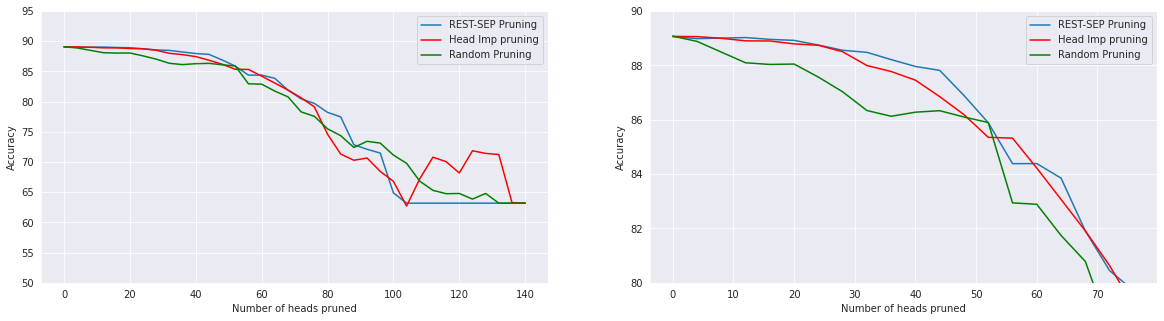

In [32]:
plt.figure(figsize = (20,5))
ax = plt.subplot(1,2,1)
ax.set_ylim(50,95)

ax.plot(xaxis, rsa_accuracies*100, label = 'REST-SEP Pruning')
ax.plot(xaxis, head_imp_accuracies*100, color = 'red', label = 'Head Imp pruning')
ax.plot(xaxis, random_accuracies*100, color = 'green', label = 'Random Pruning')

ax.set_xlabel('Number of heads pruned')
ax.set_ylabel('Accuracy')
ax.legend(loc = 'best')

ax1 = plt.subplot(1,2,2)
ax1.set_ylim(80, 90)

ax1.plot(xaxis[:20], (rsa_accuracies*100)[:20], label = 'REST-SEP Pruning')
ax1.plot(xaxis[:20], (head_imp_accuracies*100)[:20], color = 'red', label = 'Head Imp pruning')
ax1.plot(xaxis[:20], (random_accuracies*100)[:20], color = 'green', label = 'Random Pruning')

ax1.set_xlabel('Number of heads pruned')
ax1.set_ylabel('Accuracy')
ax1.legend(loc = 'best')